In [20]:
# Import the library EUMDAC
#import eumdac
import time
import fnmatch
import shutil

from IPython.core.display import HTML
import datetime
import xarray as xr
import matplotlib.pyplot as plt

# How to use the API

## Authentication

In [125]:
# Insert your personal key and secret into the single quotes

consumer_key = 'YOUR_CONSUMER_KEY'
consumer_secret = 'YOUR_CONSUMER_SECRET'

credentials = (consumer_key, consumer_secret)

token = eumdac.AccessToken(credentials)
print(f"This token '{token}' expires {token.expiration}")

This token '4b8a9235-1d5b-36bc-8641-bba9228c2104' expires 2022-11-09 10:18:39.492129


## Selecting a product from the Data Store

https://api.eumetsat.int/api-key/

In [126]:
datastore = eumdac.DataStore(token)
selected_collection = datastore.get_collection('EO:EUM:DAT:METOP:ASCSZR1B')

In [127]:
display(HTML('<b>'+selected_collection.title+'</b>'))
display(HTML('<b>ID:</b> '+str(selected_collection)))
display(HTML('<b>Abstract:</b> '+selected_collection.abstract))

In [128]:
start = datetime.datetime(2018, 10, 30, 2, 10)

end = datetime.datetime(2018, 11, 1, 2, 10)

geometry = [[41, -71], [41, -70], [40, -70], [40, -71], [41, -71]]

In [129]:
# Test Pioneer 10

lat = 40.1334
lon = -70.7785

In [130]:
 # Set bounding-box coordinates
bbox = '-71, 40, 70, 41'

# Retrieve datasets that match our filter
products = selected_collection.search(bbox=bbox)

In [131]:
products = selected_collection.search(
     #geo='POLYGON(({}))'.format(','.join(["{} {}".format(*coord) for coord in geometry])),
     bbox=bbox,
     dtstart=start,
     dtend=end)

In [132]:
products.first()

<class 'eumdac.product.Product'>(EO:EUM:DAT:METOP:ASCSZR1B, ASCA_SZR_1B_M02_20181101003000Z_20181101021158Z_N_O_20181101021149Z)

In [133]:
# Select only one 
latest = selected_collection.search().first()
latest


<class 'eumdac.product.Product'>(EO:EUM:DAT:METOP:ASCSZR1B, ASCA_SZR_1B_M01_20221109050900Z_20221109065058Z_N_O_20221109055655Z)

## Customization

In [134]:
datatailor = eumdac.DataTailor(token)

The Data Tailor, when applying customisations, simplifies the NetCDF4 products by changing/removing some of the headers and descriptions. But it's also possible to get a non-simplified NetCDF4 by changing format='netcdf4' to format='netcdf4_satellite' in your chain.

As additional information, for the netcdf-satellite (NetCDF - Data Centre) option, the format specification for the native product is described in https://www.eumetsat.int/media/38671 and the mapping between the native and the netCDF is given in http://usc.tools.eumetsat.int/docs/changelog_netCDF_v2_0.htm

The difference between 'format: netcdf4_satellite' and 'format: netcdf4' is that you can apply one or multiple customisations on 'format: netcdf4', including the feature you want, "ROI" (Region of Interest). But it's not possible to have both the ROI feature applied and have "format: netcdf4_satellite" conversion at the same time. You can see all the customisation limitations on available products in this table (see the comments column):   

https://eumetsatspace.atlassian.net/wiki/spaces/DSDT/pages/1909096468/Products+and+Customisations+Available+in+Data+Tailor

If you want to use 'format: netcdf4' though, it's possible to apply ROI customisation in your chain. The chain should be as follows:

 

chain = eumdac.tailor_models.Chain(

     product='ASCATL1SZR',

     format='netcdf4',

     roi={"NSWE":[-0.91,-2.44,-50.17,-47.64]}

     )

In [158]:
chain = eumdac.tailor_models.Chain(
     product='ASCATL1SZR',
     format='netcdf4_satellite'
     )

In [159]:
#customisation = datatailor.new_customisation(latest, chain)
customisation = datatailor.new_customisation(products.first(), chain)
customisation # By calling the newly created customisation we will start the customisation process

<class 'eumdac.customisation.Customisation'>(dd2cdf63)

In [160]:
status = "QUEUED"
sleep_time = 10 # seconds

# Customisation Loop
while status == "QUEUED" or status == "RUNNING":
    # Get the status of the ongoing customisation
    status = customisation.status

    if "DONE" in status:
        print(f"SUCCESS")
        break
    elif "ERROR" in status or 'KILLED' in status:
        print(f"UNSUCCESS, exiting")
        break
    elif "QUEUED" in status:
        print(f"QUEUED")
    elif "RUNNING" in status:
        print(f"RUNNING")
    elif "INACTIVE" in status:
        sleep_time = max(60*10, sleep_time*2)
        print(f"INACTIVE, doubling status polling time to {sleep_time} (max 10 mins)")
    time.sleep(sleep_time)

RUNNING
SUCCESS


## Download

In [161]:
customisation.outputs

['ASCATL1SZR--dd2cdf63/W_XX-EUMETSAT-Darmstadt,SURFACE+SATELLITE,METOPA+ASCAT_C_EUMP_20181101003000_62444_eps_o_125_l1.nc']

In [162]:
nc, = fnmatch.filter(customisation.outputs, '*.nc')
nc

'ASCATL1SZR--dd2cdf63/W_XX-EUMETSAT-Darmstadt,SURFACE+SATELLITE,METOPA+ASCAT_C_EUMP_20181101003000_62444_eps_o_125_l1.nc'

In [163]:
jobID= customisation._id

In [164]:
print(f"Dowloading the NetCDF output of the customisation {jobID}")

with customisation.stream_output(nc,) as stream, \
        open(stream.name, mode='wb') as fdst:
    shutil.copyfileobj(stream, fdst)

print(f"Dowloaded the NetCDF output of the customisation {jobID}")

Dowloading the NetCDF output of the customisation dd2cdf63
Dowloaded the NetCDF output of the customisation dd2cdf63


In [165]:
stream.name

'W_XX-EUMETSAT-Darmstadt,SURFACE+SATELLITE,METOPA+ASCAT_C_EUMP_20181101003000_62444_eps_o_125_l1.nc'

## Open NetCDF

data = xr.open_dataset('ASCATL1SZR_20221025T184500Z_20221025T202658Z_epct_68e304ad_F.nc')
data

In [166]:
data = xr.open_dataset(stream.name)
data

<xarray.Dataset>
Dimensions:            (numRows: 3264, numSigma: 3, numCells: 82)
Coordinates:
    sigma0             (numSigma) int16 ...
    lat                (numRows, numCells) float64 ...
    lon                (numRows, numCells) float64 ...
Dimensions without coordinates: numRows, numSigma, numCells
Data variables: (12/21)
    record_start_time  (numRows) float64 ...
    record_stop_time   (numRows) float64 ...
    utc_line_nodes     (numRows) datetime64[ns] ...
    abs_line_number    (numRows) float64 ...
    as_des_pass        (numRows) float32 ...
    sat_track_azi      (numRows) float32 ...
    ...                 ...
    f_v                (numRows, numCells, numSigma) float32 ...
    f_oa               (numRows, numCells, numSigma) float32 ...
    f_sa               (numRows, numCells, numSigma) float32 ...
    f_tel              (numRows, numCells, numSigma) float32 ...
    f_ref              (numRows, numCells, numSigma) float32 ...
    f_land             (numRows, numCells, numSigma) float32 ...
Attributes: (12/68)
    creator_name:                         EUMETSAT
    creator_url:                          http://www.eumetsat.int
    creator_email:                        ops@eumetsat.int
    institution:                          EUMETSAT
    license:                              CopyRight EUMETSAT 2022
    Conventions:                          CF-1.7
    ...                                   ...
    pixel_size_on_horizontal:             12500m
    land_seamask_file_pointer:            xxxx_LSM_xx_xxx_20060717000000Z_xxx...
    orbit_prediction_file_point:          xxxx_OSV_xx_M02_20181031000000Z_201...
    normalisation_file_pointer:           NTB_data
    processing_parameter_file_pointer:    ASCA_PRC_xx_M02_20161107000000Z_xxx...
    instrument_parameter_file_pointer:    ASCA_INS_xx_M02_20161107000000Z_xxx...

In [167]:
data.f_f

<xarray.DataArray 'f_f' (numRows: 3264, numCells: 82, numSigma: 3)>
[802944 values with dtype=float32]
Coordinates:
    sigma0   (numSigma) int16 0 1 2
    lat      (numRows, numCells) float64 ...
    lon      (numRows, numCells) float64 ...
Dimensions without coordinates: numRows, numCells, numSigma
Attributes:
    valid_min:  0
    valid_max:  10000
    long_name:  f_f flag
    units:      1
    comment:    Flag related to non-nominal amount of input raw data to calcu...

In [123]:
data.lat.max()

<xarray.DataArray 'lat' ()>
array(89.3107605)

In [117]:
data.lat.min()

<xarray.DataArray 'lat' ()>
array(-89.42802429)

In [118]:
data.lon.max()

<xarray.DataArray 'lon' ()>
array(179.98968506)

In [119]:
data.lon.min()

<xarray.DataArray 'lon' ()>
array(-179.99932861)

In [120]:
data.lon[0, 0]

<xarray.DataArray 'lon' ()>
array(-177.43817, dtype=float32)
Coordinates:
    lat      float32 68.95
    lon      float32 -177.4

In [121]:
data.lon[-1, -1]

<xarray.DataArray 'lon' ()>
array(107.63083, dtype=float32)
Coordinates:
    lat      float32 75.06
    lon      float32 107.6

# Inspect data downloaded by Martin

In [2]:
data_dir_reproj = '/lustre/storeB/project/IT/geout/machine-ocean/data_raw/metop/geographic_reproj/'
data_dir_no_reproj = '/lustre/storeB/project/IT/geout/machine-ocean/data_raw/metop/no_reproj/'

In [16]:
fname_1 = 'ASCATL1SZR_20171030T140600Z_20171030T154458Z_epct_a606ed22_P.nc'
fname_2 = 'ASCATL1SZR_20171030T150000Z_20171030T163858Z_epct_7bf81bbd_P.nc'

## Open reprojected data

In [17]:
reproj_1 = xr.open_dataset(data_dir_reproj + fname_1)
reproj_1

<xarray.Dataset>
Dimensions:              (lat: 541, lon: 1086)
Coordinates:
  * lat                  (lat) float64 89.07 88.74 88.4 ... -89.1 -89.43 -89.76
  * lon                  (lon) float64 -179.7 -179.4 -179.0 ... 179.3 179.6
Data variables: (12/44)
    azi_angle_trip_fore  (lat, lon) float32 ...
    azi_angle_trip_mid   (lat, lon) float32 ...
    azi_angle_trip_aft   (lat, lon) float32 ...
    f_f_fore             (lat, lon) float32 ...
    f_f_mid              (lat, lon) float32 ...
    f_f_aft              (lat, lon) float32 ...
    ...                   ...
    num_val_trip_aft     (lat, lon) float32 ...
    sigma0_trip_fore     (lat, lon) float32 ...
    sigma0_trip_mid      (lat, lon) float32 ...
    sigma0_trip_aft      (lat, lon) float32 ...
    swath_indicator      (lat, lon) float32 ...
    crs                  |S1 ...
Attributes: (12/34)
    Conventions:               CF-1.5
    start_sensing_time:        20171030T140600Z
    stop_sensing_time:         20171030T154458.125000Z
    EPCT_geospatial_lat_max:   79.9941
    EPCT_geospatial_lat_min:   65.0232
    EPCT_geospatial_lon_max:   331.0286
    ...                        ...
    EPCT_roi:                  null
    EPCT_sensing_start:        null
    EPCT_sensing_stop:         null
    EPCT_software_ version:    3.1.0
    EPCT_software_name:        DataTailor
    EPCT_stretch_method:       null

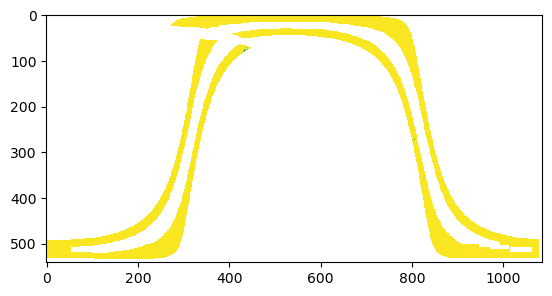

In [21]:
plt.imshow(reproj_1['sigma0_trip_fore'])

In [22]:
reproj_2 = xr.open_dataset(data_dir_reproj + fname_2)
reproj_2

<xarray.Dataset>
Dimensions:              (lat: 445, lon: 893)
Coordinates:
  * lat                  (lat) float64 89.02 88.62 88.22 ... -89.33 -89.73
  * lon                  (lon) float64 -179.7 -179.3 -178.9 ... 179.0 179.4
Data variables: (12/44)
    azi_angle_trip_fore  (lat, lon) float32 ...
    azi_angle_trip_mid   (lat, lon) float32 ...
    azi_angle_trip_aft   (lat, lon) float32 ...
    f_f_fore             (lat, lon) float32 ...
    f_f_mid              (lat, lon) float32 ...
    f_f_aft              (lat, lon) float32 ...
    ...                   ...
    num_val_trip_aft     (lat, lon) float32 ...
    sigma0_trip_fore     (lat, lon) float32 ...
    sigma0_trip_mid      (lat, lon) float32 ...
    sigma0_trip_aft      (lat, lon) float32 ...
    swath_indicator      (lat, lon) float32 ...
    crs                  |S1 ...
Attributes: (12/34)
    Conventions:               CF-1.5
    start_sensing_time:        20171030T150000Z
    stop_sensing_time:         20171030T163858.125000Z
    EPCT_geospatial_lat_max:   85.4212
    EPCT_geospatial_lat_min:   68.8663
    EPCT_geospatial_lon_max:   328.6777
    ...                        ...
    EPCT_roi:                  null
    EPCT_sensing_start:        null
    EPCT_sensing_stop:         null
    EPCT_software_ version:    3.1.0
    EPCT_software_name:        DataTailor
    EPCT_stretch_method:       null

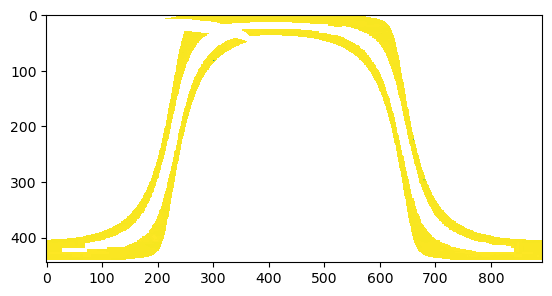

In [24]:
plt.imshow(reproj_2['sigma0_trip_fore'])

In [6]:
fname_1 = 'W_XX-EUMETSAT-Darmstadt,SURFACE+SATELLITE,METOPA+ASCAT_C_EUMP_20171030140600_57238_eps_o_125_l1.nc'

In [8]:
fname_2 = 'W_XX-EUMETSAT-Darmstadt,SURFACE+SATELLITE,METOPB+ASCAT_C_EUMP_20171030150000_26552_eps_o_125_l1.nc'